# A basic example of CNFs

This notebook walks you through a simple example that
- defines its own synthetic SCM dataset,
- define a causal normalizing flow,
- trains the model,
- evaluates the quality of the trained model.

For a tutorial on the basics of Pytorch distributions and zuko, see the previous tutorial.

In [1]:
import lightning as L
import torch

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Create a dataset

We are going to manually create a simple linear SCM, $x = Ax + u$ with $u \sim \mathcal{N}(0, I)$ and $A = \begin{pmatrix} 0 & 0 & 0 \\ 1 & 0 & 0 \\ 0.25 & 0.75 & 0 \end{pmatrix}$. Note that there exist predefined synthetic datasets in `causalflows.scms`.

In [3]:
from causalflows.scms import SCM, CausalEquations

In [4]:
class MyTriangleEqs(CausalEquations):
    def __init__(self):
        functions = [
            lambda u1: u1 + 0.0,
            lambda x1, u2: x1 + u2,
            lambda x1, x2, u3: 0.25 * x1 + 0.75 * x2 + u3,
        ]
        inverses = [
            lambda x1: x1 - 0.0,
            lambda x1, x2: x2 - x1,
            lambda x1, x2, x3: x3 - 0.75 * x2 - 0.25 * x1,
        ]

        super().__init__(functions, inverses)

    @property
    def adjacency(self):
        return torch.tensor((
            (1, 0, 0),
            (1, 1, 0),
            (1, 1, 1),
        )).bool()

In [5]:
scm = SCM(equations=MyTriangleEqs(), base='std-gaussian')


def generate_data(size: int):
    return scm.sample((size,))

In [6]:
adjacency = scm.adjacency
adjacency

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]])

Generate datasets

In [7]:
from torch.utils.data import DataLoader, TensorDataset

In [8]:
batch_size = 2048

train_size = 10000
train_data = generate_data(train_size)

test_size = int(train_size * 0.1)
test_data = generate_data(test_size)

# Create the dataloaders
train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

test_dataset = TensorDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=test_size)

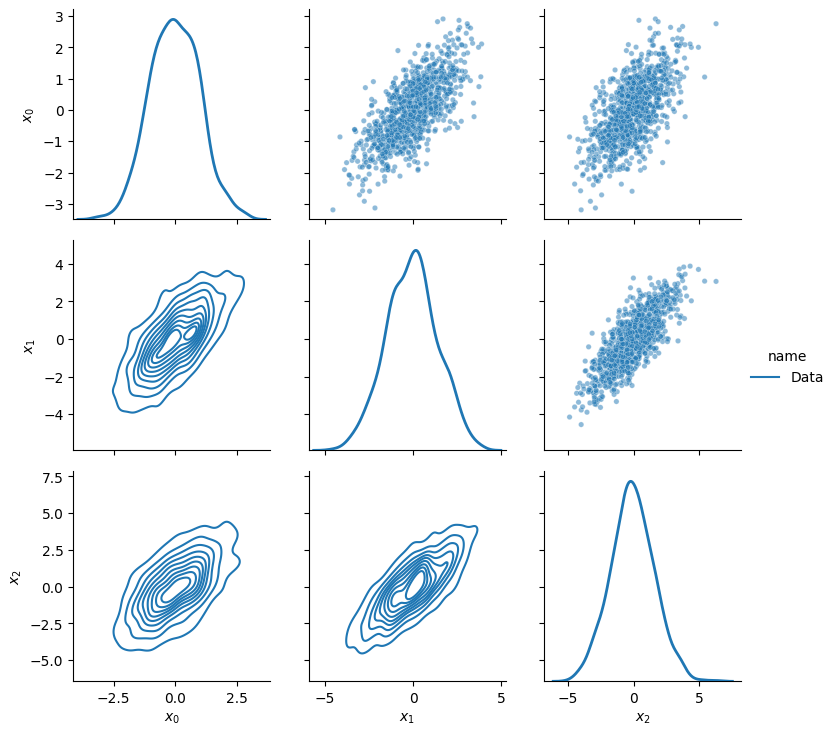

In [9]:
def create_df(tensors_dict):
    df_list = []
    for i, (k, x) in enumerate(tensors_dict.items()):
        df = pd.DataFrame(x.numpy(), columns=[f'$x_{j}$' for j in range(x.shape[1])])
        df['name'] = k
        df_list.append(df)

    df = pd.concat(df_list)
    return df


def plot_data(tensors_dict):
    df = create_df(tensors_dict)
    g = sns.PairGrid(df, diag_sharey=False, hue='name')
    g.map_upper(sns.scatterplot, s=15, alpha=0.5)
    g.map_lower(sns.kdeplot, common_norm=False)
    g.map_diag(sns.kdeplot, lw=2, common_norm=False)
    g.add_legend()
    plt.show()


plot_data({'Data': test_data})


## Using a causal flow

In [10]:
from causalflows.flows import CausalMAF

features = 3
context = 0

flow = CausalMAF(features, context, adjacency=adjacency)
flow

CausalMAF(
  (transform): MaskedAutoregressiveTransform(
    (base): MonotonicAffineTransform()
    (passes): 3
    (hyper): MaskedMLP(
      (0): MaskedLinear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): MaskedLinear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): MaskedLinear(in_features=64, out_features=6, bias=True)
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: torch.Size([3]), scale: torch.Size([3])))
)

Lightning boilerplate for logging

In [11]:
from lightning.pytorch.loggers.logger import Logger
from lightning.pytorch.utilities import rank_zero_only


class MyLogger(Logger):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.values = {}

    @property
    def name(self):
        return "MyLogger"

    @property
    def version(self):
        # Return the experiment version, int or str.
        return "0.1"

    @rank_zero_only
    def log_hyperparams(self, params):
        # params is an argparse.Namespace
        # your code to record hyperparameters goes here
        pass

    @rank_zero_only
    def log_metrics(self, metrics, step):
        # metrics is a dictionary of metric names and values
        # your code to record metrics goes here
        for k, v in metrics.items():
            if k in self.values:
                self.values[k].append(v)
            else:
                self.values[k] = [v]

    @rank_zero_only
    def save(self):
        # Optional. Any code necessary to save logger data goes here
        pass

    @rank_zero_only
    def finalize(self, status):
        # Optional. Any code that needs to be run after training
        # finishes goes here
        pass

Define the LightningModule to train the model

In [12]:
class LitFlow(L.LightningModule):
    def __init__(self, flow):
        super().__init__()
        self.flow = flow

    def training_step(self, batch, batch_idx):
        x = batch[0]
        loss = -self.flow().log_prob(x).mean()
        self.log('train_loss', loss.detach())
        self.log('log_prob', -loss.detach())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
model = LitFlow(flow)

In [13]:
logger = MyLogger()
trainer = L.Trainer(
    max_epochs=200, logger=logger, enable_checkpointing=False, log_every_n_steps=len(train_loader)
)
trainer.fit(model=model, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type      | Params | Mode 
-------------------------------------------
0 | flow | CausalMAF | 4.8 K  | train
-------------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/ajavaloy/Workspace/libraries/causal-flows/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                   | 0/? [00:00<?, …

`Trainer.fit` stopped: `max_epochs=200` reached.


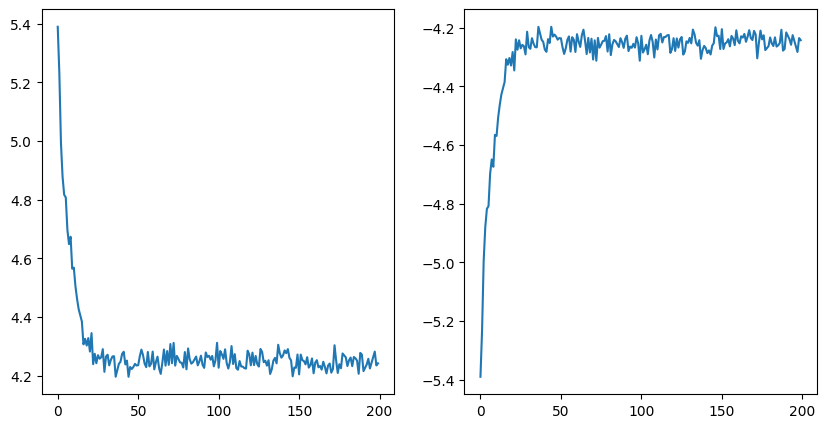

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=logger.values['epoch'], y=logger.values['train_loss'], ax=axs[0])
sns.lineplot(x=logger.values['epoch'], y=logger.values['log_prob'], ax=axs[1])
plt.show()

In [15]:
gen_data = flow().sample([test_size])
gen_data.shape

torch.Size([1000, 3])

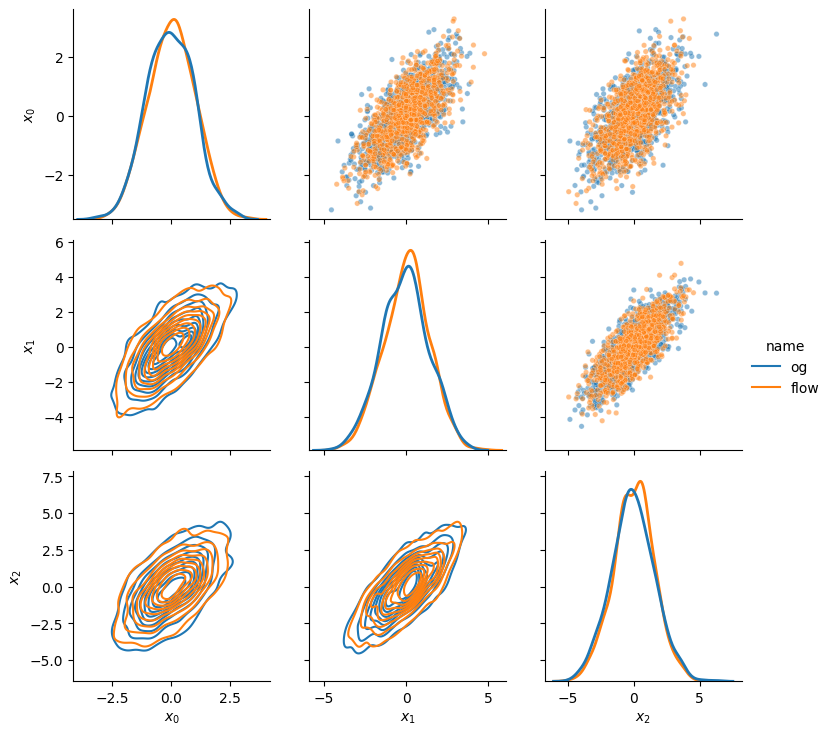

In [16]:
plot_data({'og': test_data, 'flow': gen_data})

## Generate interventional data

In [17]:
def generate_int_data(size: int, index, value):
    return scm.sample_interventional(index, value, (size,))

tensor([1])


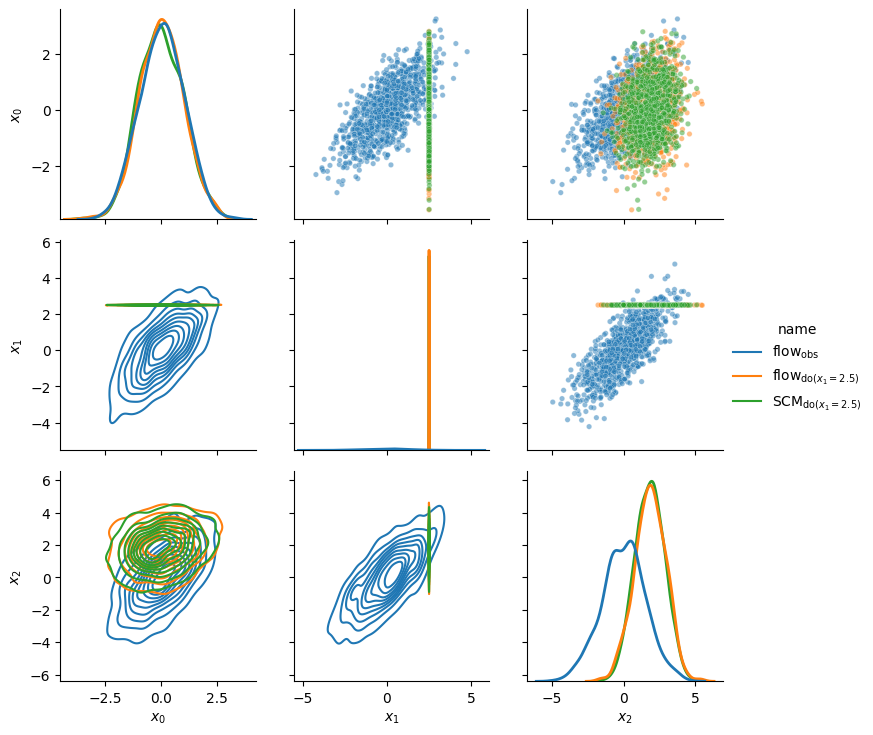

In [18]:
true_int_data = generate_int_data(test_size, 1, 2.5)

with flow().intervene(index=1, value=2.5) as int_flow:
    int_data = int_flow.sample((test_size,))

# We could also sample with the helper method
# int_data = flow().sample_interventional(index=1, value=2.5, sample_shape=(test_size,))

int_data += torch.randn((test_size, 3)) * 0.01
true_int_data += torch.randn((test_size, 3)) * 0.01

plot_data({
    r'$\text{flow}_\text{obs}$': gen_data,
    r'$\text{flow}_{\mathrm{do}(x_1 = 2.5)}$': int_data,
    r'$\text{SCM}_{\mathrm{do}(x_1 = 2.5)}$': true_int_data,
})